In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas_profiling 
import missingno as msno
from scipy import stats # statistical library
from statsmodels.stats.weightstats import ztest
%matplotlib inline
sns.set_style('white')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 3000

In [2]:
trainpath = './datasets/train.csv'

df_train = pd.read_csv(trainpath)
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
df_traincopy = df_train.copy()

In [4]:
# cleaning, reformating cols                                                          
df_train.columns = df_train.columns.str.replace(' ', '_')
df_train['2nd_Flr_SF'] = df_train['2nd_Flr_SF'].fillna(0)
df_train['Alley'] = df_train['Alley'].isna()
df_train['Alley'] = df_train['Alley'].replace([0],'No Alley')
df_train = df_train.drop_duplicates()

# add cols
def age(age_cell):
    return int(2014 - age_cell)

df_train['Age'] = df_train['Year_Built'].map(age)

df_train['total_sq'] = df_train['1st_Flr_SF'] + df_train['2nd_Flr_SF'] + df_train['Garage_Area'] 
df_train['ratio_lotsq'] = df_train['total_sq'] / df_train['Lot_Area']
df_train = df_train[df_train['total_sq'] > 100]

#MS zoning rename
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["I (all)"],'Industrial')
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["C (all)"],'Commercial')
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["A (agr)"],'Agriculture')
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["RH"],'Resi High Density')
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["RL"],'Resi Low Density')
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["RM"],'Resi Med Density')
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["FV"],'Floating Village')
df_train['MS_Zoning'] = df_train['MS_Zoning'].replace(["RP"],'Resi low Density Park')

#subclass rename
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([20],'1-STORY 1946 & NEWER')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([30],'1-STORY 1945 & OLDER')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([40],'1-STORY W/FINISHED ATTIC')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([45],'1-1/2 STORY UNFINISHED')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([50],'1-1/2 STORY FINISHED')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([60],'2-STORY 1946 & NEWER')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([70],'2-STORY 1945 & OLDER')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([75],'2-1/2 STORY')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([80],'SPLIT OR MULTI-LEVEL')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([85],'SPLIT FOYER')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([90],'DUPLEX')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([120],'1-STPUD-1946 & NEWER')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([150],'1-1/2ST PUD')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([160],'2ST PUD - 1946 & NEWER')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([180],'MULTILEVEL')
df_train['MS_SubClass'] = df_train['MS_SubClass'].replace([190],'2 FAMILY CONVERSION')

df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([10],'Very Excellent')
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([9],'Excellent')
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([8],'Very good')
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([7],'Good')
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([6],'Above Avg')
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([5],'Average')
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([4],'Below Avg')                                                         
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([3],'Fair')                                                          
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([2],'Poor')                                                          
df_train['Overall_Qual'] = df_train['Overall_Qual'].replace([1],'Very Poor')                                                          

df_train['Paved_Drive'] = df_train['Paved_Drive'].replace(['N'],'Dirt/Gravel')
df_train['Paved_Drive'] = df_train['Paved_Drive'].replace(['P'],'Partial Paved')
df_train['Paved_Drive'] = df_train['Paved_Drive'].replace(['Y'],'Paved')

df_train['Alley'] = df_train['Alley'].replace([True],1)
df_train['Alley'] = df_train['Alley'].replace([False],0)

df_train.drop(columns=['Id', 'PID', 'Lot_Frontage','Street', 'Lot_Shape', 'Land_Contour', 
                       'Utilities','Lot_Config', 'Land_Slope',  'Condition_1','Condition_2', 
                       'House_Style','Overall_Cond', 'Year_Remod/Add','Exterior_1st', 
                       'Exterior_2nd','Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond', 
                       'Foundation', 'Bsmt_Qual','Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1',
                       'BsmtFin_SF_1','BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 
                       'Total_Bsmt_SF','Heating', 'Heating_QC', 'Central_Air', 'Electrical', 
                       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath','Bsmt_Half_Bath', 
                       'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr','Kitchen_AbvGr', 
                       'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional','Fireplaces', 
                       'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt','Garage_Finish', 
                       'Garage_Cars',  'Garage_Qual','Garage_Cond',  'Wood_Deck_SF', 
                       'Open_Porch_SF','Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch', 
                       'Pool_Area', 'Pool_QC','Fence', 'Misc_Feature', 'Misc_Val', 
                        'Mo_Sold', 'Yr_Sold', 'Sale_Type','Roof_Style','Roof_Matl',
                       'Mas_Vnr_Type'],inplace = True)
                                                  
#make similar distributions                                                                                                                                                                            
df_train['SalePrice'] = df_train['SalePrice'].map(np.log)
df_train['1st_Flr_SF'] = df_train['1st_Flr_SF'].map(np.log)
df_train['2nd_Flr_SF'] = df_train['2nd_Flr_SF'].map(np.log)
df_train['Lot_Area'] = df_train['Lot_Area'].map(np.log)
df_train['Garage_Area'] = df_train['Garage_Area'].map(np.log)
df_train['total_sq'] = df_train['total_sq'].map(np.log)
                                                  
df_train.replace([np.inf, -np.inf], 0, inplace=True)
df_train.replace(np.nan, 0, inplace=True)


/Users/j_b/opt/anaconda3/lib/python3.8/site-packages/pandas/core/base.py:1145: RuntimeWarning: divide by zero encountered in log
  new_values = map_f(values, mapper)


In [5]:
df_train.head()

,MS_SubClass,MS_Zoning,Lot_Area,Alley,Neighborhood,Bldg_Type,Overall_Qual,Year_Built,1st_Flr_SF,2nd_Flr_SF,Garage_Area,Paved_Drive,SalePrice,Age,total_sq,ratio_lotsq
0,2-STORY 1946 & NEWER,Resi Low Density,9.511703,True,Sawyer,1Fam,Above Avg,1976,6.586172,6.625392,6.163315,Paved,11.779129,38,7.577634,0.144559
1,2-STORY 1946 & NEWER,Resi Low Density,9.349406,True,SawyerW,1Fam,Good,1996,6.816736,7.097549,6.326149,Paved,12.301383,18,7.893945,0.233293
2,1-STORY 1946 & NEWER,Resi Low Density,8.977399,True,NAmes,1Fam,Average,1953,6.963190,0.000000,5.505332,Paved,11.599103,61,7.172425,0.164479
3,2-STORY 1946 & NEWER,Resi Low Density,9.190342,True,Timber,1Fam,Average,2006,6.612041,6.551080,5.991465,Paved,12.066811,8,7.519692,0.188125
4,1-1/2 STORY FINISHED,Resi Low Density,9.563459,True,SawyerW,1Fam,Above Avg,1900,6.722630,6.419995,6.182085,Dirt/Gravel,11.838626,114,7.564757,0.135511


In [6]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Lot_Area,2050.0,9.092676,0.501264,7.170120,8.922658,9.151863,9.351341,11.976659
Year_Built,2050.0,1971.732683,30.166057,1872.000000,1954.000000,1974.000000,2001.000000,2010.000000
1st_Flr_SF,2050.0,7.007184,0.324410,5.811141,6.779069,6.996681,7.247793,8.536015
2nd_Flr_SF,2050.0,2.767453,3.267821,0.000000,0.000000,0.000000,6.537778,7.529406
Garage_Area,2050.0,5.807332,1.451763,0.000000,5.765191,6.173786,6.356108,7.257003
SalePrice,2050.0,12.024446,0.411411,9.456341,11.773846,11.998433,12.273731,13.323927
Age,2050.0,42.267317,30.166057,4.000000,13.000000,40.000000,60.000000,142.000000
total_sq,2050.0,7.533537,0.323302,5.811141,7.338238,7.546446,7.743053,8.862200
ratio_lotsq,2050.0,0.238311,0.143539,0.015931,0.162060,0.205669,0.259751,1.300769


In [7]:


#df_Paved = pdf[pdf['Paved_Drive'] == 'Paved_Drive']
#df_NotPaved = pdf[pdf['Paved_Drive'] != 'Dirt/Gravel']

df1 = df_train._get_numeric_data().drop(columns=['Alley','Year_Built'])

#plotdf['SalePrice'] = plotdf['SalePrice'].map(np.exp)
#df1['1st_Flr_SF'] = df1['1st_Flr_SF'].map(np.log)
#df1['2nd_Flr_SF'] = df1['2nd_Flr_SF'].map(np.log)
#df1['Lot_Area'] = df1['Lot_Area'].map(np.log)
#df1['Garage_Area'] = df1['Garage_Area'].map(np.log)
#df1['total_sq'] = df1['total_sq'].map(np.log)
#np.exp(df_test['y_hat'])






In [8]:
#df_Paved.head()

In [9]:
#df1.to_csv('tables.csv')
#path = './datasets/tables.csv'

In [10]:
#df1.hist(figsize=(15,15));

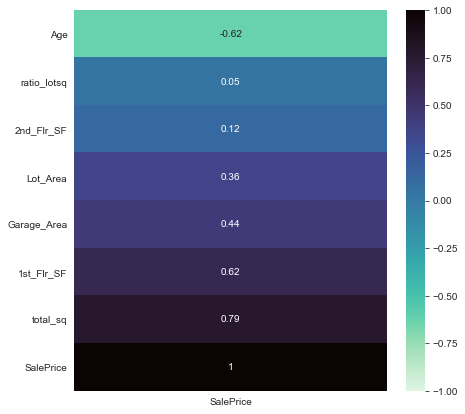

In [11]:
fig, ax = plt.subplots(figsize=(7,7)) 
sns.heatmap(df1.corr()[['SalePrice']].sort_values('SalePrice'),
            annot=True,vmin=-1,vmax=1,cmap='mako_r');

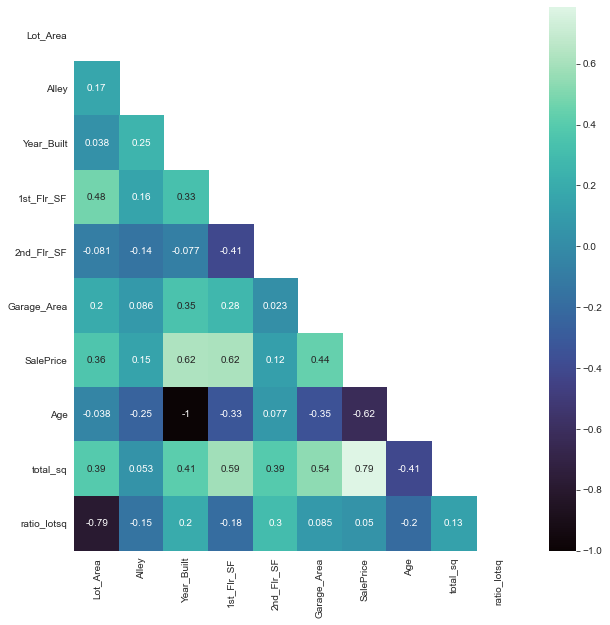

In [12]:
plt.figure(figsize = (10,10))
# Get correlation of variables.
corr = df_train.corr()  #compares every single pair of varibles in the df

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
sns.heatmap(corr,mask = mask, cmap = 'mako',annot = True);

In [13]:
#AV = AutoViz_Class()
# Let's now visualize the plots generated by AutoViz.
#report = AV.AutoViz(trainpath)

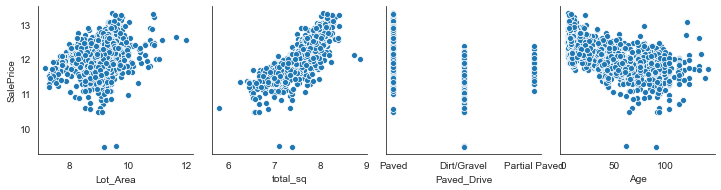

In [14]:

sns.pairplot(df_train, y_vars=['SalePrice'], x_vars=['Lot_Area', 
                                                     'total_sq',
                                                     'Paved_Drive','Age'
                                                    ])

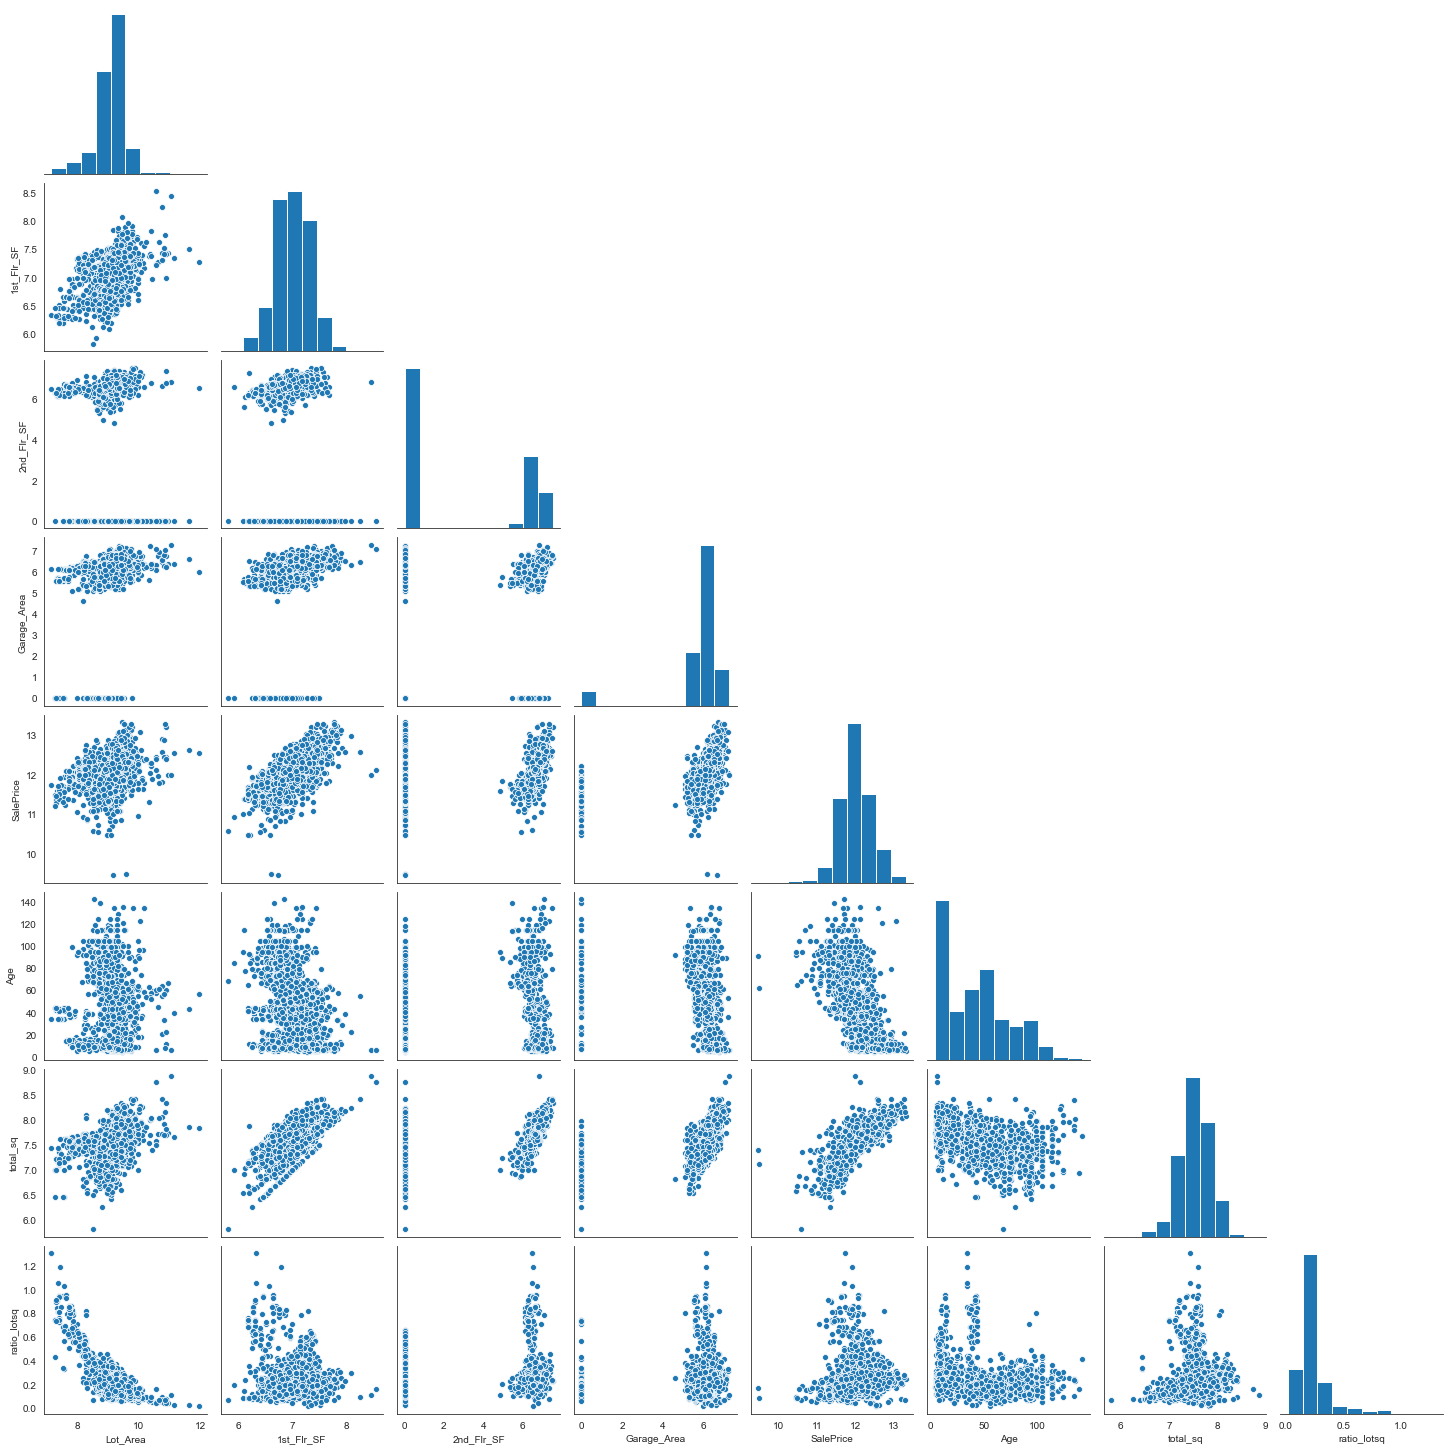

In [15]:

#scatter plot matrix https://seaborn.pydata.org/examples/scatterplot_matrix.html
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Plot our correlation heatmap, while masking the upper triangle to be white.

sns.pairplot(df1,corner=True,hue_order='SalePrice');

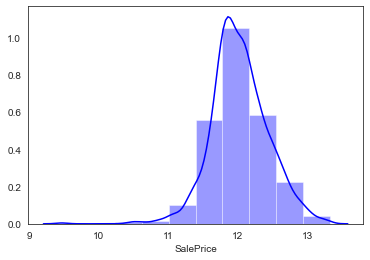

In [16]:
sns.distplot(df1['SalePrice'],kde=True,bins=10,color='blue',axlabel='SalePrice');

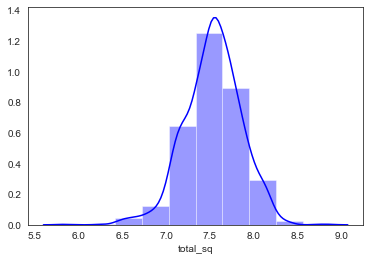

In [17]:
sns.distplot(df1['total_sq'],color='blue',bins=10,axlabel='total_sq');

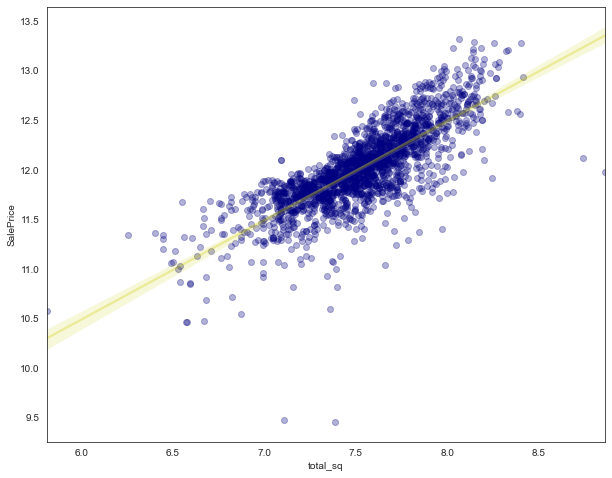

In [18]:
plt.figure(figsize = (10,8))
sns.regplot(df1.total_sq, df1.SalePrice, data = df1, truncate = True,ci=99,
            scatter_kws = {'color': 'navy', 'alpha': 0.3},
            line_kws = {'color': '#CCCC00', 'alpha': 0.3})

<Figure size 720x576 with 0 Axes>

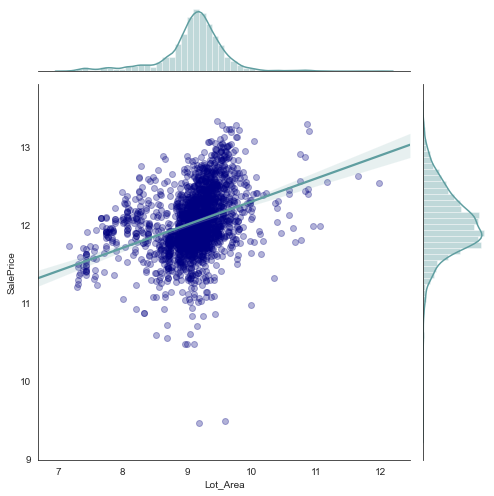

In [19]:
plt.figure(figsize = (10,8));
sns.jointplot(x="Lot_Area", y="SalePrice", data=df1,ci=99,
              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
              kind="reg", truncate=False,
              color="cadetblue", height=7);
#plt.axvline(8,color='r')
# Create a descriptive title
#plt.title('T')

<Figure size 720x576 with 0 Axes>

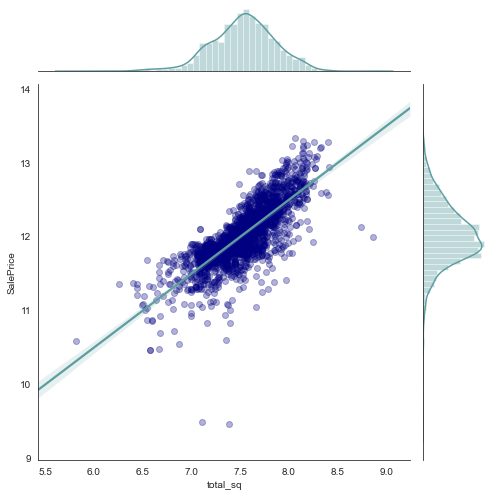

In [20]:
plt.figure(figsize = (10,8));
sns.jointplot(x="total_sq", y="SalePrice", data=df1,ci=99,
              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
              kind="reg", truncate=False,
              color="cadetblue", height=7);

<Figure size 720x576 with 0 Axes>

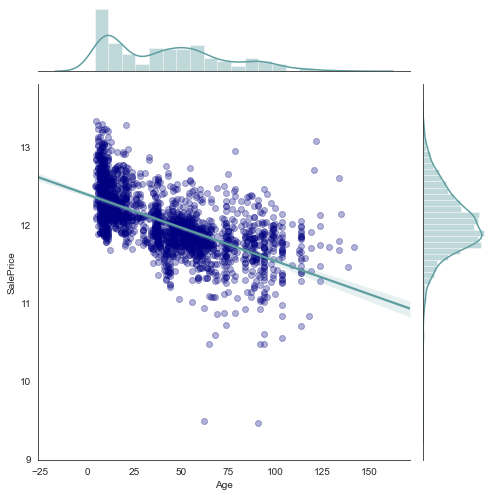

In [21]:
plt.figure(figsize = (10,8));
sns.jointplot(x="Age", y="SalePrice", data=df1,ci=99,
              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
              kind="reg", truncate=False,
              color="cadetblue", height=7);

<Figure size 720x576 with 0 Axes>

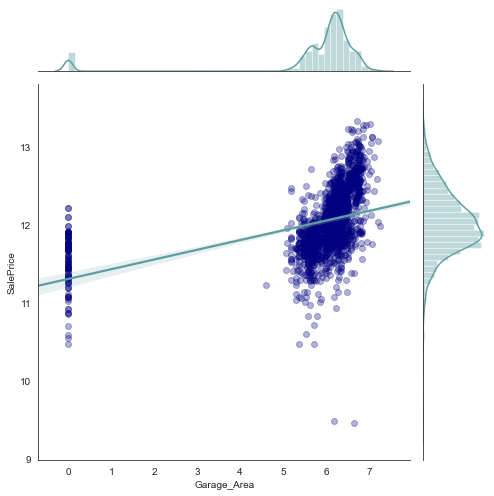

In [22]:
plt.figure(figsize = (10,8));
sns.jointplot(x="Garage_Area", y="SalePrice", data=df1,ci=99,
              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
              kind="reg", truncate=False,
              color="cadetblue", height=7);

In [23]:
df_train.head()

,MS_SubClass,MS_Zoning,Lot_Area,Alley,Neighborhood,Bldg_Type,Overall_Qual,Year_Built,1st_Flr_SF,2nd_Flr_SF,Garage_Area,Paved_Drive,SalePrice,Age,total_sq,ratio_lotsq
0,2-STORY 1946 & NEWER,Resi Low Density,9.511703,True,Sawyer,1Fam,Above Avg,1976,6.586172,6.625392,6.163315,Paved,11.779129,38,7.577634,0.144559
1,2-STORY 1946 & NEWER,Resi Low Density,9.349406,True,SawyerW,1Fam,Good,1996,6.816736,7.097549,6.326149,Paved,12.301383,18,7.893945,0.233293
2,1-STORY 1946 & NEWER,Resi Low Density,8.977399,True,NAmes,1Fam,Average,1953,6.963190,0.000000,5.505332,Paved,11.599103,61,7.172425,0.164479
3,2-STORY 1946 & NEWER,Resi Low Density,9.190342,True,Timber,1Fam,Average,2006,6.612041,6.551080,5.991465,Paved,12.066811,8,7.519692,0.188125
4,1-1/2 STORY FINISHED,Resi Low Density,9.563459,True,SawyerW,1Fam,Above Avg,1900,6.722630,6.419995,6.182085,Dirt/Gravel,11.838626,114,7.564757,0.135511


<Figure size 720x576 with 0 Axes>

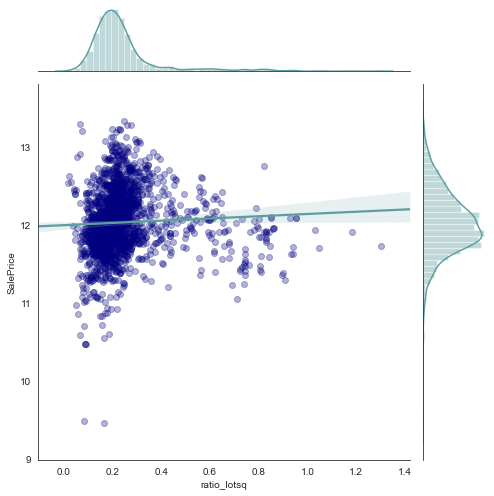

In [24]:
plt.figure(figsize = (10,8));
sns.jointplot(x="ratio_lotsq", y="SalePrice", data=df_train,ci=99,
              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
              kind="reg", truncate=False,
              color="cadetblue", height=7);

In [33]:

#plt.figure(figsize = (10,8));
#sns.jointplot(x="Paved_Drive", y="SalePrice", data=df_train,ci=99,
#              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
#              kind="reg", truncate=False,
#              color="cadetblue", height=7);



ValueError: Could not interpret input 'Paved_Drive_Dirt/Gravel'

<Figure size 720x576 with 0 Axes>

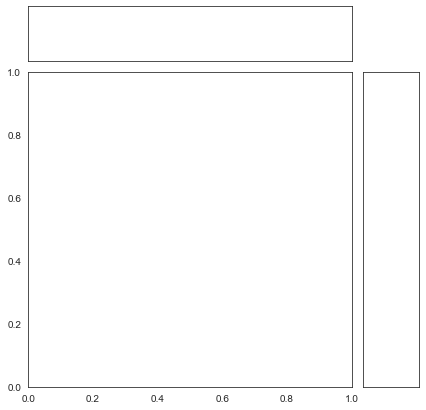

In [26]:
plt.figure(figsize = (10,8));
sns.jointplot(x="Paved_Drive_Dirt/Gravel", y="SalePrice", data=df_train,ci=99,
              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
              kind="reg", truncate=False,
              color="cadetblue", height=7);

ValueError: Could not interpret input 'Alley_False'

<Figure size 720x576 with 0 Axes>

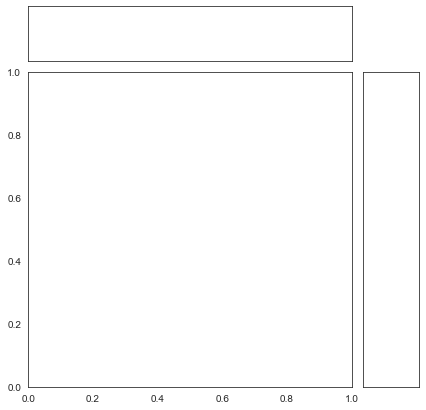

In [27]:
plt.figure(figsize = (10,8));
sns.jointplot(x="Alley_False", y="SalePrice", data=df_train,ci=99,
              scatter_kws = {'color': 'navy', 'alpha': 0.3},    
              kind="reg", truncate=False,
              color="cadetblue", height=7);

In [32]:
df_train.head()

,Lot_Area,Alley,Year_Built,1st_Flr_SF,2nd_Flr_SF,Garage_Area,SalePrice,Age,total_sq,ratio_lotsq,MS_SubClass_1-1/2 STORY FINISHED,MS_SubClass_1-1/2 STORY UNFINISHED,MS_SubClass_1-1/2ST PUD,MS_SubClass_1-STORY 1945 & OLDER,MS_SubClass_1-STORY 1946 & NEWER,MS_SubClass_1-STORY W/FINISHED ATTIC,MS_SubClass_1-STPUD-1946 & NEWER,MS_SubClass_2 FAMILY CONVERSION,MS_SubClass_2-1/2 STORY,MS_SubClass_2-STORY 1945 & OLDER,MS_SubClass_2-STORY 1946 & NEWER,MS_SubClass_2ST PUD - 1946 & NEWER,MS_SubClass_DUPLEX,MS_SubClass_MULTILEVEL,MS_SubClass_SPLIT FOYER,MS_SubClass_SPLIT OR MULTI-LEVEL,MS_Zoning_Agriculture,MS_Zoning_Commercial,MS_Zoning_Floating Village,MS_Zoning_Industrial,MS_Zoning_Resi High Density,MS_Zoning_Resi Low Density,MS_Zoning_Resi Med Density,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Bldg_Type_1Fam,Bldg_Type_2fmCon,Bldg_Type_Duplex,Bldg_Type_Twnhs,Bldg_Type_TwnhsE,Overall_Qual_Above Avg,Overall_Qual_Average,Overall_Qual_Below Avg,Overall_Qual_Excellent,Overall_Qual_Fair,Overall_Qual_Good,Overall_Qual_Poor,Overall_Qual_Very Excellent,Overall_Qual_Very Poor,Overall_Qual_Very good,Paved_Drive_Dirt/Gravel,Paved_Drive_Partial Paved,Paved_Drive_Paved
0,9.511703,True,1976,6.586172,6.625392,6.163315,11.779129,38,7.577634,0.144559,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,9.349406,True,1996,6.816736,7.097549,6.326149,12.301383,18,7.893945,0.233293,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,8.977399,True,1953,6.963190,0.000000,5.505332,11.599103,61,7.172425,0.164479,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,9.190342,True,2006,6.612041,6.551080,5.991465,12.066811,8,7.519692,0.188125,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,9.563459,True,1900,6.722630,6.419995,6.182085,11.838626,114,7.564757,0.135511,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [30]:






dist_a = df_train[df_train['Paved_Drive'] == 1]

dist_b = df_train[df_train['Paved_Drivel' == 3 ]





In [31]:
#Z-test: Checking if the distribution means are statistically different
t_stat, p_value = ztest(dist_a, dist_b)
print("----- Z Test Results -----")
print("T stat. = " + str(t_stat))
print("P value = " + str(p_value)) # P-value is less than 0.05

print("")

#T-test: Checking if the distribution means are statistically different
t_stat_2, p_value_2 = stats.ttest_ind(dist_a, dist_b)
print("----- T Test Results -----")
print("T stat. = " + str(t_stat_2))
print("P value = " + str(p_value_2)) # P-value is less than 0.05

----- Z Test Results -----
T stat. = 96.68798426366409
P value = 0.0

----- T Test Results -----
T stat. = 96.68798426366409
P value = 0.0


In [ ]:
#df_train.to_csv('Tableau.csv',index=False)




High correlation
Id is highly correlated with Yr_Sold

garage area shows postive relation to SalePrice



In [ ]:
#dfw[dfnew.MS_Zoning != 'I (all)']

In [ ]:
#df_train.to_csv('./datasets/train_features1.csv')

In [ ]:
#patht = './datasets/train_features1.csv'

In [ ]:
#dfnew[dfnew.MS_Zoning != 'I (all)']
#df.drop(df.index[2])